In [ ]:
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 14.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805891 sha256=d58ba25dd044a826931bc819334563163487e4f6734075b315c45e9655ee69ab
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


In [ ]:
!pip install seaborn

In [ ]:
from pyspark.sql import SparkSession
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import when, col
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc, asc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import drive


In [ ]:
# Session
spark = SparkSession.builder \
    .master("local[2]") \
    .appName("CrimeData") \
    .getOrCreate()

# Access content
sc = spark.sparkContext


Task 1: Loading and Preprocessing the Dataset (10%)

In [ ]:
# Google Drive Mount
drive.mount('/content/drive')

# Loading monthly files for each county

path2crimes = "/content/drive/MyDrive/data_crime"

# LOADING DERBYSHIRE
derbyshire_df = spark.read.csv(f"{path2crimes}/*derbyshire*.csv", header=True, inferSchema=True)

# LOADING LEICESTERSHIRE
leicestershire_df = spark.read.csv(f"{path2crimes}/*leicestershire*.csv", header=True, inferSchema=True)

# LOADING KENT
kent_df = spark.read.csv(f"{path2crimes}/*kent*.csv", header=True, inferSchema=True)

Mounted at /content/drive


In [ ]:
# Display the schema for each county dataframe to understand the structure of the data
print("Schema for Derbyshire DataFrame:")
derbyshire_df.printSchema()

print("\nSchema for Leicestershire DataFrame:")
leicestershire_df.printSchema()

print("\nSchema for Kent DataFrame:")
kent_df.printSchema()

# Show the first 5 rows of each county dataframe with full content
print("\nFirst 5 rows of Derbyshire DataFrame:")
derbyshire_df.show(5, truncate=False)

print("\nFirst 5 rows of Leicestershire DataFrame:")
leicestershire_df.show(5, truncate=False)

print("\nFirst 5 rows of Kent DataFrame:")
kent_df.show(5, truncate=False)


Schema for Derbyshire DataFrame:
root
 |-- Crime ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)


Schema for Leicestershire DataFrame:
root
 |-- Crime ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |

In [ ]:
# Define the file pattern to load all monthly data for 2022
crime_file_pattern = "/content/drive/MyDrive/data_crime/*street.csv"

# Load all crime data for Derbyshire, Leicestershire, and Kent for all months of 2022
crime_df = spark.read.csv(crime_file_pattern, header=True, inferSchema=True)

# Show the first 15 rows of the loaded crime data (without truncating content)
print("First 15 rows of the loaded crime data:")
crime_df.show(15, truncate=False)


First 15 rows of the loaded crime data:
+----------------------------------------------------------------+-------------------+-----------+------------+---------+---------+----------------------------+---------+------------+----------------------------+---------------------------------------------+-------+
|Crime ID                                                        |Month              |Reported by|Falls within|Longitude|Latitude |Location                    |LSOA code|LSOA name   |Crime type                  |Last outcome category                        |Context|
+----------------------------------------------------------------+-------------------+-----------+------------+---------+---------+----------------------------+---------+------------+----------------------------+---------------------------------------------+-------+
|b93c5583a3adce8a042621fd374c8353a629b27f4f321b7921b8e5a93539a191|2022-08-01 00:00:00|Kent Police|Kent Police |0.973355 |51.260972|On or near Lower Ensden Road

In [ ]:
# Rename columns into a single dataframe
crime_df = crime_df.withColumnRenamed("Crime ID", "Crime_ID") \
                   .withColumnRenamed("Month", "Month") \
                   .withColumnRenamed("Reported by", "Reported_by") \
                   .withColumnRenamed("LSOA code", "LSOA_code") \
                   .withColumnRenamed("LSOA name", "LSOA_name") \
                   .withColumnRenamed("Crime type", "Crime_type") \
                   .withColumnRenamed("Last outcome category", "Last_outcome_category")

# Display the schema of the dataframe to verify column renaming
print("Schema of the crime data after renaming columns:")
crime_df.printSchema()

# Show the first 5 rows of the renamed dataframe to validate the data
print("\nFirst 5 rows of the renamed crime data:")
crime_df.show(5, truncate=False)


Schema of the crime data after renaming columns:
root
 |-- Crime_ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)


First 5 rows of the renamed crime data:
+----------------------------------------------------------------+-------------------+-----------+------------+---------+---------+----------------------------+---------+------------+-------------------------+---------------------------------------------+-------+
|Crime_ID                                                        |Month              |Reported_by|Falls within|Longitude|Latitude |Locat

In [ ]:
# Define a mapping to standardize 'Reported_by' values to county names
county_mapping = {
    "Derbyshire Constabulary": "Derbyshire",
    "Leicestershire Police": "Leicestershire",
    "Kent Police": "Kent"
}

# Add a new 'County' column based on the 'Reported_by' column using the defined mapping


crime_df = crime_df.withColumn(
    "County",
    when(crime_df["Reported_by"] == "Derbyshire Constabulary", "Derbyshire")
    .when(crime_df["Reported_by"] == "Leicestershire Police", "Leicestershire")
    .when(crime_df["Reported_by"] == "Kent Police", "Kent")
    .otherwise("Unknown")  # Default to 'Unknown' for any other unexpected values
)

# Display the 'Reported_by' and 'County' columns to verify the new 'County' column
crime_df.select("Reported_by", "County").show(5)


+-----------+------+
|Reported_by|County|
+-----------+------+
|Kent Police|  Kent|
|Kent Police|  Kent|
|Kent Police|  Kent|
|Kent Police|  Kent|
|Kent Police|  Kent|
+-----------+------+
only showing top 5 rows



In [ ]:
# Scheme with new 'County' Column
crime_df.printSchema()
crime_df.show(5, truncate=False)

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)
 |-- County: string (nullable = false)

+----------------------------------------------------------------+-------------------+-----------+------------+---------+---------+----------------------------+---------+------------+-------------------------+---------------------------------------------+-------+------+
|Crime_ID                                                        |Month              |Reported_by|Falls within|Longitude|Latitude |Location                    |LSOA_code|LSOA_name 

Task 2: Descriptive Data Analysis using Spark SQL (15%)

In [ ]:
# Register the DataFrame as a temporary SQL table to run SQL queries
crime_df.createOrReplaceTempView("data_crime")

# SQL query to calculate the total number of crimes per county
total_crimes_by_county = spark.sql("""
    SELECT County, COUNT(*) AS Total_Crimes
    FROM data_crime
    GROUP BY County
    ORDER BY Total_Crimes DESC
""")

# Display the result showing total crimes by county, sorted by highest number of crimes
print("Total crimes by county:")
total_crimes_by_county.show()


Total crimes by county:
+--------------+------------+
|        County|Total_Crimes|
+--------------+------------+
|          Kent|      200945|
|Leicestershire|      115179|
|    Derbyshire|      110805|
+--------------+------------+



In [ ]:
# SQL query to calculate the total number of crimes per month for each county
monthly_crime_permonth = spark.sql("""
    SELECT
        County,
        substring(Month, 6, 2) AS Month,
        COUNT('Reported_by') AS Total_Crimes
    FROM data_crime
    GROUP BY County, Month
    ORDER BY County, Month
""")

# Display the total crimes per month by county, sorted by County and Month
print("Monthly crime trends for each county:")
monthly_crime_permonth.show()


Monthly crime trends for each county:
+----------+-----+------------+
|    County|Month|Total_Crimes|
+----------+-----+------------+
|Derbyshire|   01|        8991|
|Derbyshire|   02|        8452|
|Derbyshire|   03|        9598|
|Derbyshire|   04|        9409|
|Derbyshire|   05|       10140|
|Derbyshire|   06|        9710|
|Derbyshire|   07|       10017|
|Derbyshire|   08|        9571|
|Derbyshire|   09|        8781|
|Derbyshire|   10|        9205|
|Derbyshire|   11|        8923|
|Derbyshire|   12|        8008|
|      Kent|   01|       16338|
|      Kent|   02|       15383|
|      Kent|   03|       17310|
|      Kent|   04|       17144|
|      Kent|   05|       17546|
|      Kent|   06|       17388|
|      Kent|   07|       17950|
|      Kent|   08|       18365|
+----------+-----+------------+
only showing top 20 rows



In [ ]:
# Define the window specification: partition by 'County' and order by 'Total_Crimes' in descending order
window_spec = Window.partitionBy("County").orderBy(desc("Total_Crimes"))

# Add row numbers for ranking:
#  'Rank_Highest' for the highest crime month within each county
#  'Rank_Lowest' for the lowest crime month within each county
ranked_crimes = monthly_crime_permonth.withColumn(
    "Rank_Highest", row_number().over(window_spec)
).withColumn(
    "Rank_Lowest", row_number().over(window_spec.orderBy("Total_Crimes"))
)

# Filter to get the highest and lowest crime months for each county
highest_crimes = ranked_crimes.filter(col("Rank_Highest") == 1) \
    .select("County", "Month", "Total_Crimes") \
    .withColumnRenamed("Total_Crimes", "Highest_Crimes")

lowest_crimes = ranked_crimes.filter(col("Rank_Lowest") == 1) \
    .select("County", "Month", "Total_Crimes") \
    .withColumnRenamed("Total_Crimes", "Lowest_Crimes")

# Output the results: highest and lowest crime months for each county
print("Months with the Highest Number of Crimes:")
highest_crimes.show()

print("Months with the Lowest Number of Crimes:")
lowest_crimes.show()

Months with the Highest Number of Crimes:
+--------------+-----+--------------+
|        County|Month|Highest_Crimes|
+--------------+-----+--------------+
|    Derbyshire|   05|         10140|
|          Kent|   08|         18365|
|Leicestershire|   08|         10373|
+--------------+-----+--------------+

Months with the Lowest Number of Crimes:
+--------------+-----+-------------+
|        County|Month|Lowest_Crimes|
+--------------+-----+-------------+
|    Derbyshire|   12|         8008|
|          Kent|   12|        14976|
|Leicestershire|   02|         8482|
+--------------+-----+-------------+



In [ ]:
# SQL query to calculate the number of crimes by type for each county
crime_type_amount = spark.sql("""
    SELECT
        County,
        Crime_type AS Crime_Type,
        COUNT("Reported_by") AS Crime_Count
    FROM data_crime
    GROUP BY County, Crime_type
    ORDER BY County, Crime_Count DESC
""")

# Display the results showing the crime type count by county
print("Crime type distribution by county:")
crime_type_amount.show(truncate=False)


Crime type distribution by county:
+----------+----------------------------+-----------+
|County    |Crime_Type                  |Crime_Count|
+----------+----------------------------+-----------+
|Derbyshire|Violence and sexual offences|41878      |
|Derbyshire|Anti-social behaviour       |23038      |
|Derbyshire|Public order                |10198      |
|Derbyshire|Criminal damage and arson   |8724       |
|Derbyshire|Other theft                 |6821       |
|Derbyshire|Vehicle crime               |4669       |
|Derbyshire|Shoplifting                 |4237       |
|Derbyshire|Burglary                    |3806       |
|Derbyshire|Drugs                       |2292       |
|Derbyshire|Other crime                 |2053       |
|Derbyshire|Possession of weapons       |949        |
|Derbyshire|Robbery                     |769        |
|Derbyshire|Theft from the person       |767        |
|Derbyshire|Bicycle theft               |604        |
|Kent      |Violence and sexual offences|83341 

In [ ]:
#  window_spec_desc for ranking based on descending order of crime count (most common crimes)
#  window_spec_asc for ranking based on ascending order of crime count (least common crimes)
window_spec_desc = Window.partitionBy("County").orderBy(desc("Crime_Count"))
window_spec_asc = Window.partitionBy("County").orderBy(asc("Crime_Count"))

# Rank crime types within each county:
#  Rank_Desc for most frequent crimes (descending order)
#  Rank_Asc for least frequent crimes (ascending order)
ranked_crime_types_desc = crime_type_amount.withColumn("Rank_Desc", row_number().over(window_spec_desc))
ranked_crime_types_asc = crime_type_amount.withColumn("Rank_Asc", row_number().over(window_spec_asc))

# Filter to get the most common and least common crimes for each county
most_common_crimes = ranked_crime_types_desc.filter(col("Rank_Desc") == 1) \
    .select("County", "Crime_Type", "Crime_Count") \
    .withColumnRenamed("Crime_Count", "Most_Common_Crimes")

least_common_crimes = ranked_crime_types_asc.filter(col("Rank_Asc") == 1) \
    .select("County", "Crime_Type", "Crime_Count") \
    .withColumnRenamed("Crime_Count", "Least_Common_Crimes")

# Display results for most common and least common crimes by county
print("Most Common Crime Types by County:")
most_common_crimes.show(truncate=False)

print("Least Common Crime Types by County:")
least_common_crimes.show(truncate=False)

Most Common Crime Types by County:
+--------------+----------------------------+------------------+
|County        |Crime_Type                  |Most_Common_Crimes|
+--------------+----------------------------+------------------+
|Derbyshire    |Violence and sexual offences|41878             |
|Kent          |Violence and sexual offences|83341             |
|Leicestershire|Violence and sexual offences|44019             |
+--------------+----------------------------+------------------+

Least Common Crime Types by County:
+--------------+---------------------+-------------------+
|County        |Crime_Type           |Least_Common_Crimes|
+--------------+---------------------+-------------------+
|Derbyshire    |Bicycle theft        |604                |
|Kent          |Theft from the person|1007               |
|Leicestershire|Robbery              |811                |
+--------------+---------------------+-------------------+



Task 3: Data Visualization (15%)

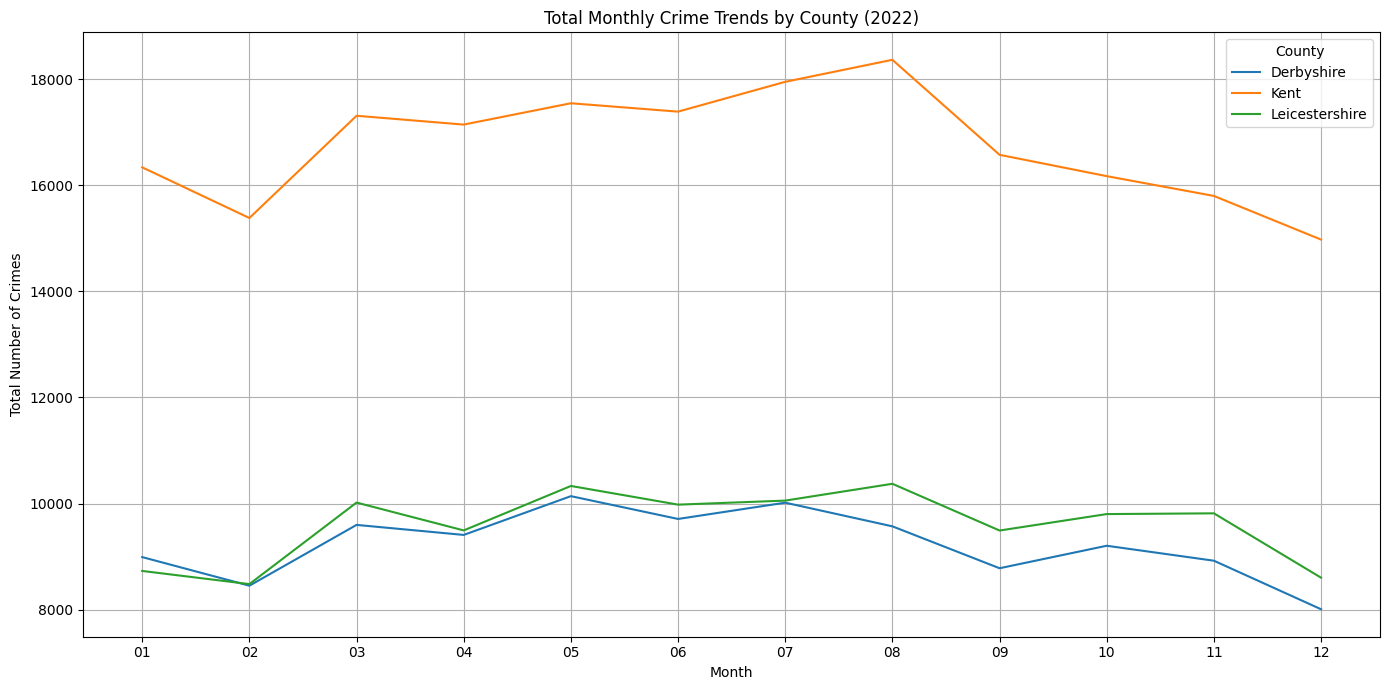

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
monthly_crime_trends_pd = monthly_crime_permonth.toPandas()

# Set up the figure and layout for the plot
plt.figure(figsize=(14, 7))

# Plot the total number of crimes per month for each county
for county in monthly_crime_trends_pd['County'].unique():
    # Filter data for the specific county
    county_data = monthly_crime_trends_pd[monthly_crime_trends_pd['County'] == county]

    # Plot total crimes for the given county across months
    plt.plot(county_data['Month'], county_data['Total_Crimes'], label=county)

# Customize the plot with titles and labels
plt.title("Total Monthly Crime Trends by County (2022)")
plt.xlabel("Month")
plt.ylabel("Total Number of Crimes")
plt.legend(title="County")
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

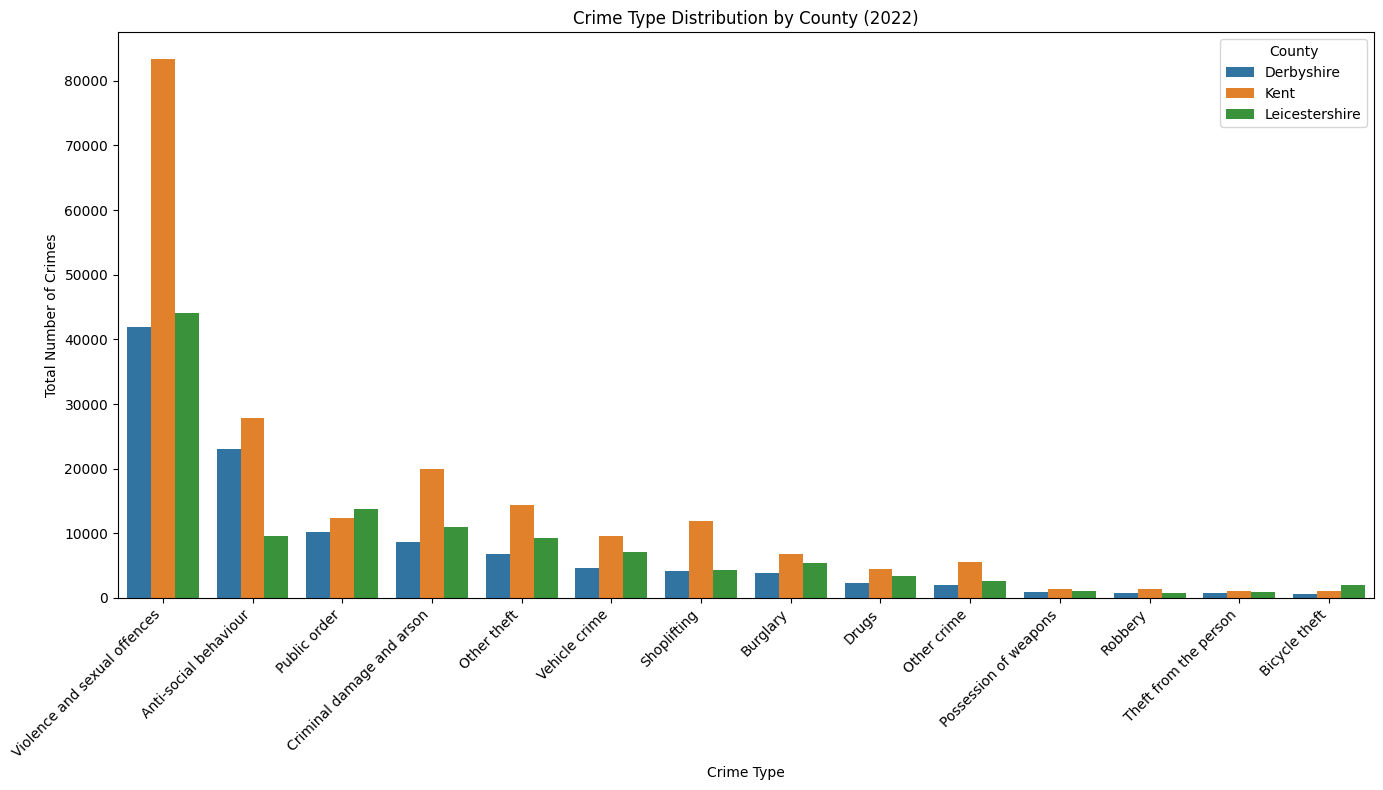

In [ ]:
crime_type_distribution = spark.sql("""
    SELECT
        County,
        Crime_type AS Crime_Type,
        COUNT(*) AS Crime_Count
    FROM data_crime
    GROUP BY County, Crime_type
    ORDER BY County, Crime_Count DESC
""")

#  Convert the Spark DataFrame to a Pandas DataFrame
crime_type_distribution_pd = crime_type_distribution.toPandas()

# Set up the figure size and layout for the plot
plt.figure(figsize=(14, 8))

# Create a grouped bar plot
sns.barplot(data=crime_type_distribution_pd, x="Crime_Type", y="Crime_Count", hue="County")

# Rotate x-axis labels for enhanced readability
plt.xticks(rotation=45, ha='right')

#  Adding titles and labels to the plot
plt.xlabel("Crime Type")
plt.ylabel("Total Number of Crimes")
plt.title("Crime Type Distribution by County (2022)")

# Display 'County'
plt.legend(title="County")

plt.tight_layout()

# Display the plot
plt.show()

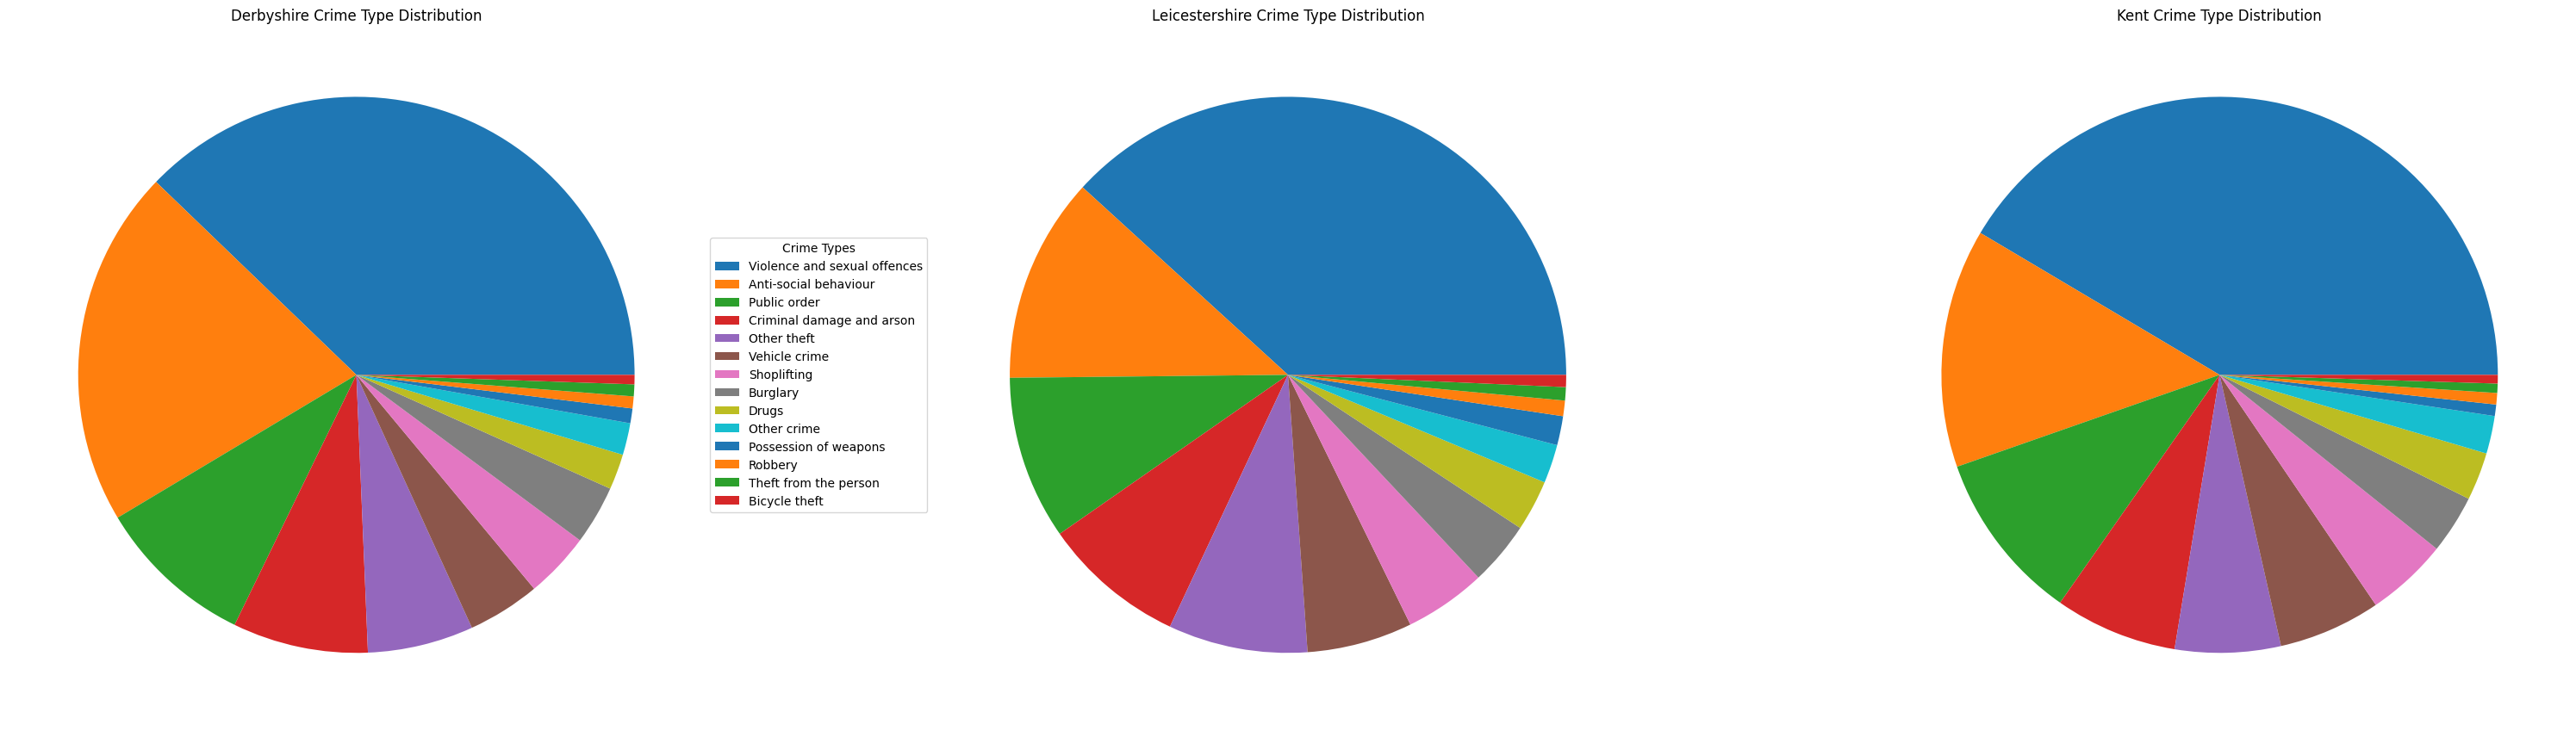

In [ ]:
# Separate data for Derbyshire, Leicestershire, and Kent based on the 'County' column
derbyshire_data = crime_type_distribution_pd[crime_type_distribution_pd['County'] == 'Derbyshire']
leicestershire_data = crime_type_distribution_pd[crime_type_distribution_pd['County'] == 'Leicestershire']
kent_data = crime_type_distribution_pd[crime_type_distribution_pd['County'] == 'Kent']

# Set up the figure with 3 subplots (one for each county)
fig, axs = plt.subplots(1, 3, figsize=(30, 11))

# Color palette for the pie charts
colors = plt.cm.tab20.colors

# Plot Derbyshire pie chart
axs[0].pie(derbyshire_data['Crime_Count'])
axs[0].set_title("Derbyshire Crime Type Distribution")
axs[0].legend(derbyshire_data['Crime_Type'], title="Crime Types", bbox_to_anchor=(1, 0.5), loc="center left")

# Plot Leicestershire pie chart
axs[1].pie(leicestershire_data['Crime_Count'])
axs[1].set_title("Leicestershire Crime Type Distribution")

# Plot Kent pie chart
axs[2].pie(kent_data['Crime_Count'])
axs[2].set_title("Kent Crime Type Distribution")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the pie charts
plt.show()